<a href="https://colab.research.google.com/github//SmartSoundKAIST/KSNVE2022AISummer/blob/main/8_1_DCASE2020_WaveNet_slider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2022년 인공지능 강습회 2일차 실습 코드**
## **Practice 9 : Prediction-based Unsupervised Detection of Anomalous Sounds for Machine Condition Monitoring (DCASE 2020 WaveNet)**

**Description**

Anomalous Sound Detection (ASD) is the task to identify whether the sound emmited from a target machine is normal or anomalous. 
The main challenge of this task is to detect unknown anomalous sounds under the condition that only normal sound samples have been provided as training data. 💻




# 0. Google Drive Mounting

**[Important!]**
Before running this code, you need to upload the train dataset and test dataset to your Google drive. You can download `slider_train` and `slider_test` from provided links.

`slider_train` : https://drive.google.com/file/d/1j5N4mLgOZxKwVnb01Pq4r7iRJeVyLgW_/view?usp=sharing


`slider_test` : https://drive.google.com/file/d/1z2MmGaWFcv9bgkf8zxeWCSGVZ_swQhLR/view?usp=sharing

Download both `.zip` files and upload them to your Google drive. Your root path of Google drive would be `gdrive/MyDrive/`, so if you upload to other paths, you need to change `root_path` in the code below.

In [ ]:
!gdown https://drive.google.com/uc?id=1j5N4mLgOZxKwVnb01Pq4r7iRJeVyLgW_         # slider train
!gdown https://drive.google.com/uc?id=1z2MmGaWFcv9bgkf8zxeWCSGVZ_swQhLR         # slider test

!unzip -qq -n slider_train.zip -d ./slider_train/                               # unzip slider train
!unzip -qq -n slider_test.zip -d ./slider_test/                                 # unzip slider test

!pip install torchinfo                                                          # install torchinfo module

Downloading...
From: https://drive.google.com/uc?id=1j5N4mLgOZxKwVnb01Pq4r7iRJeVyLgW_
To: /content/slider_train.zip
100% 694M/694M [00:09<00:00, 70.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z2MmGaWFcv9bgkf8zxeWCSGVZ_swQhLR
To: /content/slider_test.zip
100% 323M/323M [00:05<00:00, 61.6MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Import Packages

New library imported for this project:


*   `librosa`: a python package for music and audio analysis (https://librosa.org/doc/latest/index.html)
  - We use to get spectrograms from sound data
*   `glob`: package to reading files

In [ ]:
import os
import sys
import librosa
import librosa.core
import librosa.feature
import librosa.display
import glob
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from torchinfo import summary
import IPython.display as ipd

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


# 2. Hyperparameters

Set dataset folder path and hyperparameters.

In [ ]:
# Dataset path setting
dataset_dir = './slider_train'
test_dir = './slider_test'
model_dir = './model'

# Parameters for mel-spectrogram
n_fft = 2048
hop_length = 512
n_mels = 128
power = 2

# Parameters for WaveNet
n_mul = 4
kernel_size = 3

# Training parameters
EPOCHS = 100
BATCH = 32

# 3. Function Definition

For the convenience of the code, we define some functions below here.

- `file_load` : reads one 10-sec sound file and returns 1D array `y` and sampling rate `sr`

- `file_list_generator` : returns file_name list in `target_dir`

- `file_to_log_mel` : convert one file to log-mel spectrogram for use as input to the model

- `list_to_dataset` : returns a total dataset of train data


In [ ]:
def file_load(wav_name):
  try:
    return librosa.load(wav_name, sr=None, mono=False)
  except:
    print('file_broken or not exists!! : {}'.format(wav_name))
    

def file_list_generator(target_dir):
  training_list_path = os.path.abspath('{dir}/*.wav'.format(dir=target_dir))
  files = sorted(glob.glob(training_list_path))
  if len(files) == 0:
    print('no_wav_file!!')
  return files


def file_to_log_mel(file_name, n_mels, n_fft, hop_length, power):
  y, sr = file_load(file_name)
  mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                   sr=sr,
                                                   n_fft=n_fft,
                                                   hop_length=hop_length,
                                                   n_mels=n_mels,
                                                   power=power)
  log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
  return log_mel_spectrogram


def list_to_dataset(file_list, n_mels, n_fft, hop_length, power):
  for idx in tqdm(range(len(file_list))):
    log_mel = file_to_log_mel(file_list[idx],
                              n_mels=n_mels,
                              n_fft=n_fft,
                              hop_length=hop_length,
                              power=power)
    if idx == 0:
      dataset = np.zeros((len(file_list), len(log_mel[:,0]), len(log_mel[0,:])), float)
    dataset[idx, :, :] = log_mel
  return dataset

# 4. Dataset and Dataloader

Create a train dataset using the functions defined above.

In [ ]:
dataset_dir = os.path.abspath(dataset_dir)
machine_type = os.path.split(dataset_dir)[1]
model_file_path = '{model}/model_{machine_type}'.format(model=model_dir, machine_type=machine_type)

files = file_list_generator(dataset_dir)
train_data = list_to_dataset(files,
                             n_mels=n_mels,
                             n_fft=n_fft,
                             hop_length=hop_length,
                             power=power)

100%|██████████| 2804/2804 [01:12<00:00, 38.61it/s]


In [ ]:
train_dataset = torch.Tensor(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

# 5. Define a Prediction Model (WaveNet)

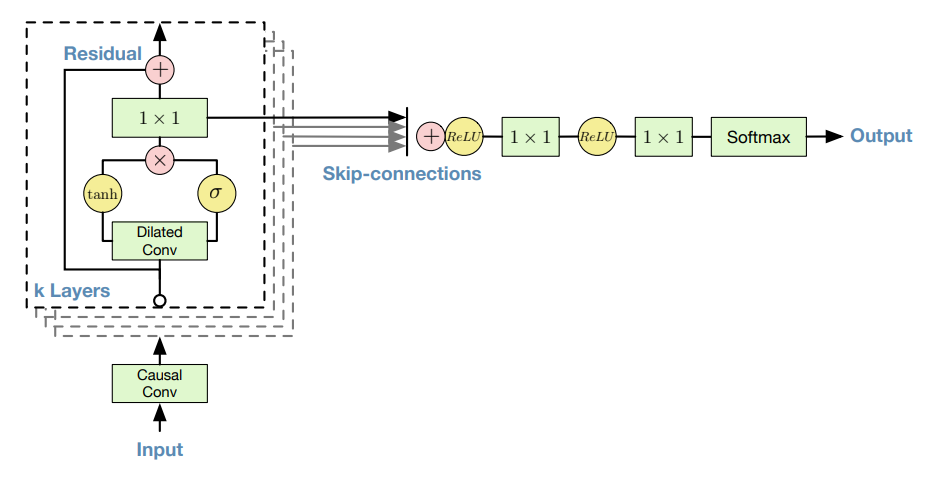

WaveNet is a generative model for raw audio waveforms. The model is fully probabilistic and autoregressive, with the predicctive distribution for each audio sample conditioned on all previous ones. In anomaly detection, WaveNet applied in the frequency domain instead of the time domain. The mdel predicts the next frame in the spectrogram of a recording of interests, and the difference between the prediction and the actual frame is used to detect anomaly data.

For more deteils, you can refer to the WaveNet paper: https://arxiv.org/pdf/1609.03499.pdf

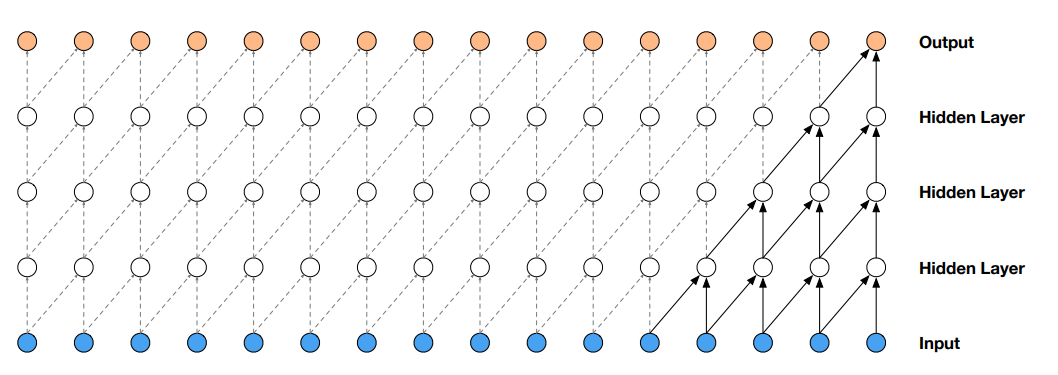

The main ingredient of WaveNet are causal convolutions. By using causal convolutions, we make sure the model cannot violate the ordering in which we model the data: the prediction 𝒫(𝑥(t) | 𝑥(1), ..., 𝑥(t-1)) emitted by the model at timestep t cannot depend on any of the future 𝑥(t+1), 𝑥(t+2), ..., 𝑥(T) as shown in figure.



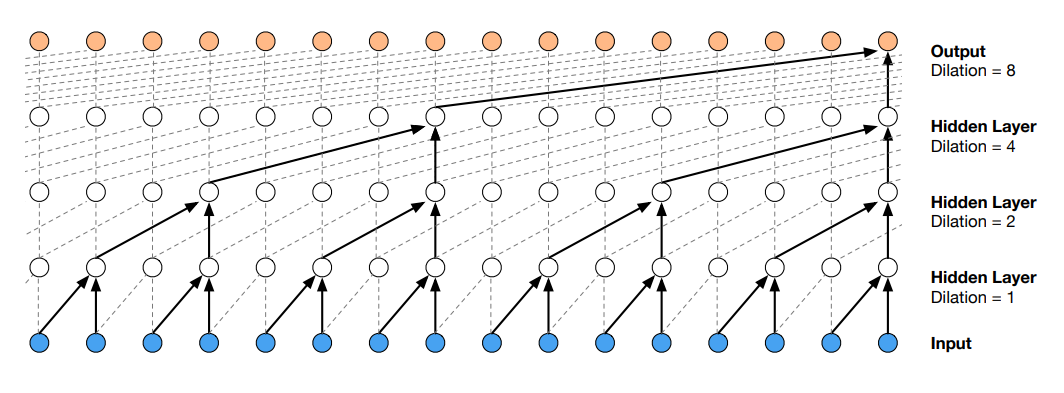

A dilated convolution is a convolution where the filter is applied over an area larager than its length by skipping input values with a certain step. It is equivalent to a convolution with a larger filter derived from the original filter by dilating it with zeros, but is significantly more efficient. Figure depicts dilated causal convolutions for dilations 1, 2, 4, and 8 with kernel size 2.

In [ ]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.conv1 = self.causal_conv(self.in_channels, self.out_channels, self.kernel_size, self.dilation)
        self.padding = self.conv1.padding[0]

    def causal_conv(self, in_channels, out_channels, kernel_size, dilation):
        pad = (kernel_size - 1) * dilation
        return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation)

    def forward(self, x):
        x = self.conv1(x)
        x = x[:, :, :-self.padding]
        return x


class ResidualBlock(nn.Module):
    def __init__(self, n_channel, n_mul, kernel_size, dilation_rate):
        super(ResidualBlock, self).__init__()
        self.n_channel = n_channel
        self.n_mul = n_mul
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.n_filter = self.n_channel * self.n_mul

        self.sigmoid_group_norm = nn.GroupNorm(1, self.n_filter)
        self.sigmoid_conv = CausalConv1d(self.n_filter, self.n_filter, self.kernel_size, self.dilation_rate)
        self.tanh_group_norm = nn.GroupNorm(1, self.n_filter)
        self.tanh_conv = CausalConv1d(self.n_filter, self.n_filter, self.kernel_size, self.dilation_rate)

        self.skip_group_norm = nn.GroupNorm(1, self.n_filter).to(device)
        self.skip_conv = nn.Conv1d(self.n_filter, self.n_channel, 1)
        self.residual_group_norm = nn.GroupNorm(1, self.n_filter)
        self.residual_conv = nn.Conv1d(self.n_filter, self.n_filter, 1)

    def forward(self, x):
        x1 = self.sigmoid_group_norm(x)
        x1 = self.sigmoid_conv(x1)
        x2 = self.tanh_group_norm(x)
        x2 = self.tanh_conv(x2)
        x1 = nn.Sigmoid()(x1)
        x2 = nn.Tanh()(x2)
        x = x1 * x2
        x1 = self.skip_group_norm(x)
        skip = self.skip_conv(x1)
        x2 = self.residual_group_norm(x)
        residual = self.residual_conv(x2)
        return skip, residual


class WaveNet(nn.Module):
    def __init__(self, n_channel, n_mul, kernel_size):
        super(WaveNet, self).__init__()
        self.n_channel = n_channel
        self.n_mul = n_mul
        self.kernel_size = kernel_size

        self.n_filter = self.n_channel * self.n_mul
        self.group_norm1 = nn.GroupNorm(1, self.n_channel)
        self.conv1 = nn.Conv1d(self.n_channel, self.n_filter, 1)

        self.block1 = ResidualBlock(self.n_channel, self.n_mul, self.kernel_size, 1)
        self.block2 = ResidualBlock(self.n_channel, self.n_mul, self.kernel_size, 2)
        self.block3 = ResidualBlock(self.n_channel, self.n_mul, self.kernel_size, 4)

        self.relu1 = nn.ReLU()
        self.group_norm2 = nn.GroupNorm(1, self.n_channel)
        self.conv2 = nn.Conv1d(self.n_channel, self.n_channel, 1)
        self.relu2 = nn.ReLU()
        self.group_norm3 = nn.GroupNorm(1, self.n_channel)
        self.conv3 = nn.Conv1d(self.n_channel, self.n_channel, 1)

    def forward(self, x):
        x = self.group_norm1(x)
        x = self.conv1(x)
        skip1, x = self.block1(x)
        skip2, x = self.block2(x)
        skip3, x = self.block3(x)
        skip = skip1 + skip2 + skip3
        x = self.relu1(skip)
        x = self.group_norm2(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.group_norm3(x)
        x = self.conv3(x)
        output = x[:, :, self.get_receptive_field() - 1:-1]
        return output

    def get_receptive_field(self):
        receptive_field = 1
        for _ in range(3):
            receptive_field = receptive_field * 2 + self.kernel_size - 2
        return receptive_field

In [ ]:
model = WaveNet(n_mels, n_mul, kernel_size).to(device)
summary(model, input_size=(BATCH, n_mels, 313))

Layer (type:depth-idx)                   Output Shape              Param #
WaveNet                                  [32, 128, 298]            --
├─GroupNorm: 1-1                         [32, 128, 313]            256
├─Conv1d: 1-2                            [32, 512, 313]            66,048
├─ResidualBlock: 1-3                     [32, 128, 313]            --
│    └─GroupNorm: 2-1                    [32, 512, 313]            1,024
│    └─CausalConv1d: 2-2                 [32, 512, 313]            --
│    │    └─Conv1d: 3-1                  [32, 512, 315]            786,944
│    └─GroupNorm: 2-3                    [32, 512, 313]            1,024
│    └─CausalConv1d: 2-4                 [32, 512, 313]            --
│    │    └─Conv1d: 3-2                  [32, 512, 315]            786,944
│    └─GroupNorm: 2-5                    [32, 512, 313]            1,024
│    └─Conv1d: 2-6                       [32, 128, 313]            65,664
│    └─GroupNorm: 2-7                    [32, 512, 313]  

# 6. Define a Loss Function & Optimizers

WaveNet learns to predict the future data the same as the original data, so we can make WaveNet's loss function to Mean Squared Error(MSE) of input data and  predicted data.

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 7. Train

Define a `train` function.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, X in enumerate(dataloader):
    X = X.to(device)

    pred = model(X)
    receptive_field = model.get_receptive_field()

    loss = loss_fn(pred, X[:, :, receptive_field:])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 30 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>5f}  [{current:>5d}/{size:>5d}]")

Model Training

In [ ]:
for t in range(EPOCHS):
  print(f"Epoch {t + 1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)

Epoch 1
-------------------------------
loss: 669.372437  [    0/ 2804]
loss: 524.026306  [  960/ 2804]
loss: 361.141937  [ 1920/ 2804]
Epoch 2
-------------------------------
loss: 200.898880  [    0/ 2804]
loss: 126.643219  [  960/ 2804]
loss: 56.913723  [ 1920/ 2804]
Epoch 3
-------------------------------
loss: 39.330654  [    0/ 2804]
loss: 23.446508  [  960/ 2804]
loss: 24.134645  [ 1920/ 2804]
Epoch 4
-------------------------------
loss: 21.406506  [    0/ 2804]
loss: 17.925068  [  960/ 2804]
loss: 18.026691  [ 1920/ 2804]
Epoch 5
-------------------------------
loss: 17.336157  [    0/ 2804]
loss: 20.477110  [  960/ 2804]
loss: 18.395918  [ 1920/ 2804]
Epoch 6
-------------------------------
loss: 14.927835  [    0/ 2804]
loss: 16.806322  [  960/ 2804]
loss: 14.851277  [ 1920/ 2804]
Epoch 7
-------------------------------
loss: 16.198330  [    0/ 2804]
loss: 11.910316  [  960/ 2804]
loss: 14.879090  [ 1920/ 2804]
Epoch 8
-------------------------------
loss: 11.291712  [    0/

# 8. Test Dataset Generation

In [ ]:
normal_files = sorted(glob.glob('{dir}/normal_*'.format(dir=test_dir)))
anomaly_files = sorted(glob.glob('{dir}/anomaly_*'.format(dir=test_dir)))

normal_labels = np.zeros(len(normal_files))
anomaly_labels = np.ones(len(anomaly_files))

test_files = np.concatenate((normal_files, anomaly_files), axis=0)
y_true = np.concatenate((normal_labels, anomaly_labels), axis=0)
y_pred = [0. for k in test_files]

In [ ]:
test_dataset = list_to_dataset(test_files, n_mels, n_fft, hop_length, power)
receptive_field = model.get_receptive_field()

100%|██████████| 1290/1290 [00:27<00:00, 47.47it/s]


# 9-1. Test 1
Predition loss for anomaly score  


In [ ]:
def get_anomaly_score1(true, pred):
  anomaly_score = nn.MSELoss()(true, pred)
  return anomaly_score

In [ ]:
for file_idx in tqdm(range(len(test_files)), desc='test data '):
  data = torch.tensor(test_dataset[file_idx], dtype=torch.float32).unsqueeze(0).to(device)
  output = model(data)

  score = get_anomaly_score1(data[:, :, receptive_field:], output)
  y_pred[file_idx] = score.cpu().detach().numpy()

test data : 100%|██████████| 1290/1290 [00:05<00:00, 245.73it/s]


Text(0, 0.5, 'TPR')

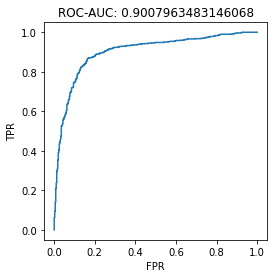

In [ ]:
auc = metrics.roc_auc_score(y_true, y_pred)
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr)
plt.title('ROC-AUC: {}'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')

# 9-2. Test 2
Mahalanobis distance for anomaly score

We can define the time-averaged frequency spectrum as an input vector and calculate Mahalanobis distance as an anomaly score. We can get statistical distribution `mean` and `cov` from train dataset.

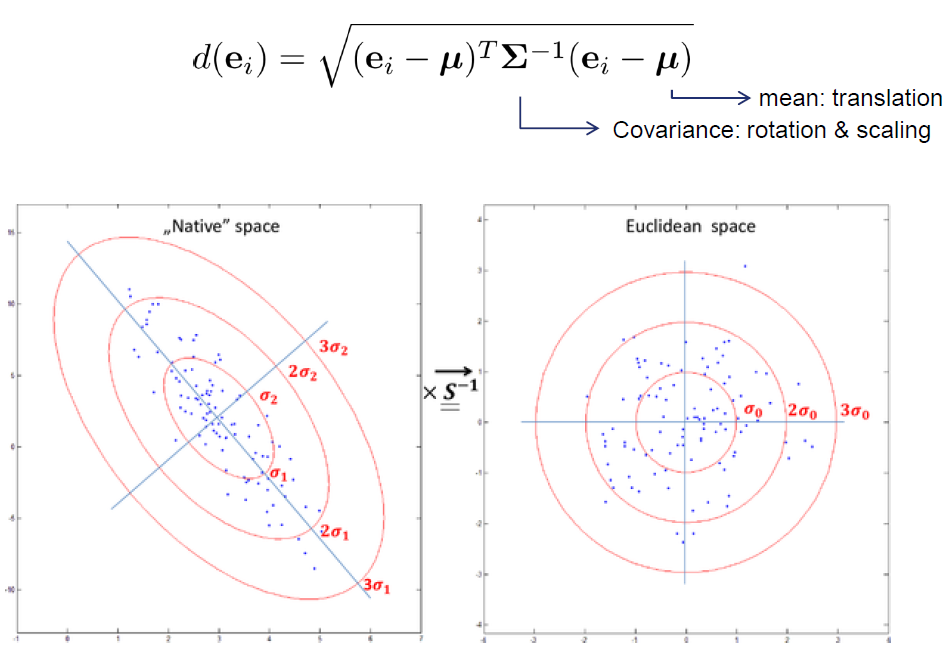

In [ ]:
train_error = []
for X in train_dataloader:
  X = X.to(device)
  output = model(X)
  receptive_field = model.get_receptive_field()
  error = output - X[:, :, receptive_field:]
  train_error.extend(error.cpu().detach().numpy())

train_error = np.mean(np.array(train_error), axis=2)
mean = np.mean(train_error, axis=0)
cov = np.cov(np.transpose(train_error))
inv_cov = np.linalg.inv(cov)

In [ ]:
def get_anomaly_score2(x, mean, inv_cov):
  vector = x - mean
  tmp = np.matmul(vector, inv_cov)
  anomaly_score = np.sqrt(np.matmul(tmp, np.transpose(vector)))
  return anomaly_score

In [ ]:
for file_idx in tqdm(range(len(test_files)), desc='test data '):
  data = torch.tensor(test_dataset[file_idx], dtype=torch.float32).unsqueeze(0).to(device)
  output = model(data)
  error = (output - data[:, :, receptive_field:]).cpu().detach().numpy()
  score = get_anomaly_score2(np.mean(error, axis=(0, 2)), mean, inv_cov)
  y_pred[file_idx] = score

test data : 100%|██████████| 1290/1290 [00:06<00:00, 194.56it/s]


Text(0, 0.5, 'TPR')

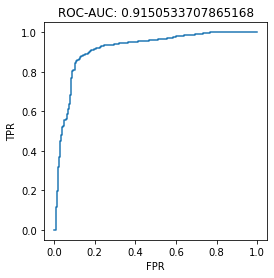

In [ ]:
auc = metrics.roc_auc_score(y_true, y_pred)
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr)
plt.title('ROC-AUC: {}'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')

# 10. Image Comparison

You can see input data and reconstructed output of sound data.

**[Normal data]**

In [ ]:
normal_data = './slider_test/normal_id_00_00000000.wav'
y, sr = file_load(normal_data)
ipd.Audio(y, rate=sr)

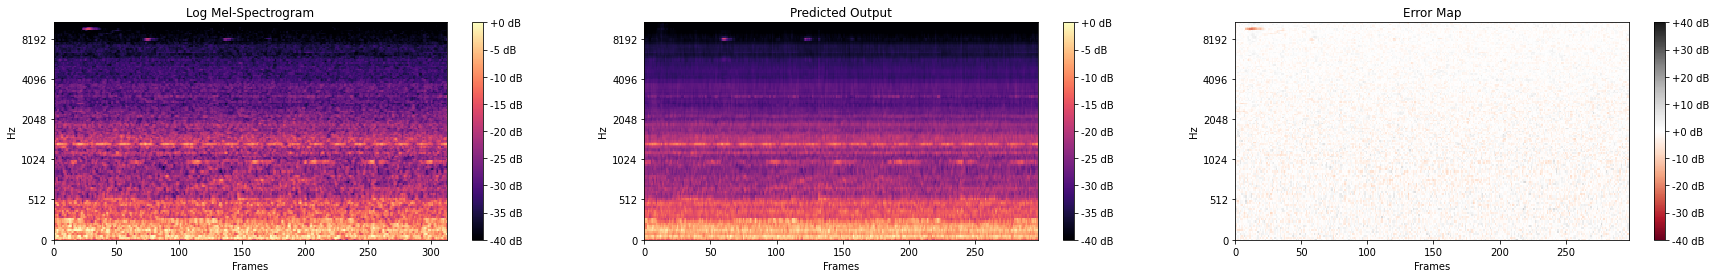

In [ ]:
normal_log_mel = file_to_log_mel(normal_data, n_mels, n_fft, hop_length, power)
output_log_mel = model(torch.Tensor(normal_log_mel).unsqueeze(0).to(device))
log_mel_error = output_log_mel.detach().cpu().numpy().squeeze() - normal_log_mel[:, receptive_field:]

plt.figure(figsize=(30, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(normal_log_mel, cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, x_axis='frames', y_axis='mel')
plt.title('Log Mel-Spectrogram')
plt.colorbar(format='%+2.f dB')

plt.subplot(1, 3, 2)
librosa.display.specshow(output_log_mel.detach().cpu().numpy().squeeze(), cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, x_axis='frames', y_axis='mel')
plt.title('Predicted Output')
plt.colorbar(format='%+2.f dB')

plt.subplot(1, 3, 3)
librosa.display.specshow(log_mel_error, cmap=plt.get_cmap('RdGy'), vmin=-40, vmax=40, x_axis='frames', y_axis='mel')
plt.title('Error Map')
plt.colorbar(format='%+2.f dB')

**[Anomaly data]**

In [ ]:
anomaly_data = './slider_test/anomaly_id_00_00000000.wav'
y, sr = file_load(anomaly_data)
ipd.Audio(y, rate=sr)

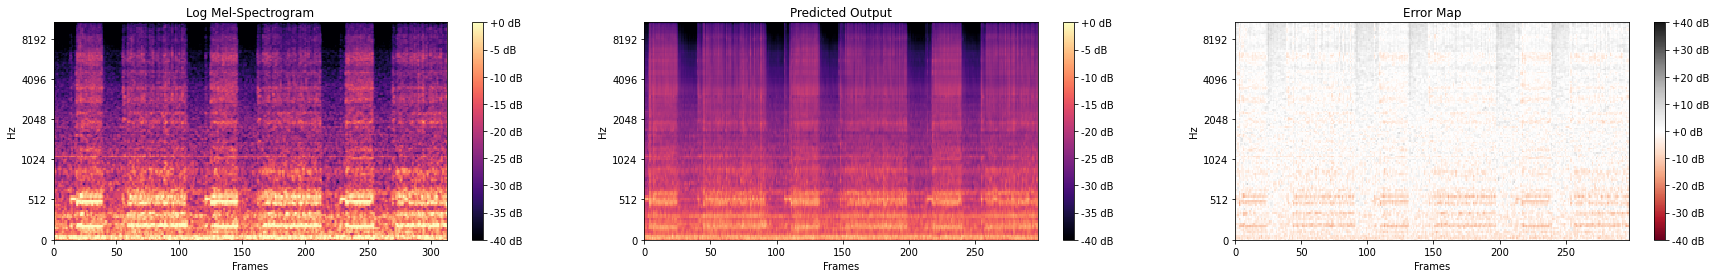

In [ ]:
anomaly_log_mel = file_to_log_mel(anomaly_data, n_mels, n_fft, hop_length, power)
output_log_mel = model(torch.Tensor(anomaly_log_mel).unsqueeze(0).to(device))
log_mel_error = output_log_mel.detach().cpu().numpy().squeeze() - anomaly_log_mel[:, receptive_field:]

plt.figure(figsize=(30, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(anomaly_log_mel, cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, x_axis='frames', y_axis='mel')
plt.title('Log Mel-Spectrogram')
plt.colorbar(format='%+2.f dB')

plt.subplot(1, 3, 2)
librosa.display.specshow(output_log_mel.detach().cpu().numpy().squeeze(), cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, x_axis='frames', y_axis='mel')
plt.title('Predicted Output')
plt.colorbar(format='%+2.f dB')

plt.subplot(1, 3, 3)
librosa.display.specshow(log_mel_error, cmap=plt.get_cmap('RdGy'), vmin=-40, vmax=40, x_axis='frames', y_axis='mel')
plt.title('Error Map')
plt.colorbar(format='%+2.f dB')